In [ ]:
import sys, os
# path to SpaOTsc
sys.path.append('/home/SpaOTsc')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from spaotsc import SpaOTsc
from sklearn.metrics import matthews_corrcoef, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import binarize, normalize
from sklearn.mixture import GaussianMixture
from scipy import sparse
import seaborn as sns

%pwd

In [ ]:
dirs = []

for tree in [1, 3, 5]:
    for ncell in [500, 800]:
        for ngene in [110, 200, 500]:
            for sigma in [0.1, 0.5]:
                for seed in [1, 2, 3, 4]:
                    root_dir = f"~/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                    dirs.append(root_dir)

In [55]:
def get_results(dirs, talk=False, gio=False):
    df = pd.DataFrame({"method": [], "prc": [], "roc": []})
    df_plt = pd.DataFrame()
    
    dirs = []

    for tree in [5]:
        for ncell in [500, 800]:
            for ngene in [110, 200, 500]:
                for sigma in [0.1, 0.5]:
                    for seed in [1, 2, 3, 4]:
                        root_dir = f"~/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        dirs.append(root_dir)
    
    seed = 0
    count = 0
    for root_dir in dirs:
        seed += 1
        spaot = pd.read_csv(os.path.join(root_dir, 'spaot_results.csv'), index_col=0)
        
        gt = pd.DataFrame(0, index=spaot.index, columns=spaot.columns)
        cci_table = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
        for index, row in cci_table.iterrows():
            gt.loc[f"{row['ligand']}-{row['receptor']}", f"CT{row['ct1']}-CT{row['ct2']}"] = 1
        gt = gt.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        # print(gt.values.sum() / gt.size)
        spaot = spaot.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        
        assert spaot.size == gt.size

        y_true = gt.reindex(sorted(gt.columns), axis=1).to_numpy().reshape(-1)
        y_aot = spaot.reindex(sorted(spaot.columns), axis=1).to_numpy().reshape(-1)
        
        if gio:
            giotto = pd.read_csv(os.path.join(root_dir, 'giotto_result_PI.csv'), index_col=0)
            giotto = giotto.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
            y_giotto = giotto.reindex(sorted(giotto.columns), axis=1).to_numpy().reshape(-1)
            # print(spaot.size, giotto.size)
            if (spaot.size != giotto.size):
                continue
            assert spaot.size == giotto.size 
        
        if talk:
            spatalk = pd.read_csv(os.path.join(root_dir, 'spatalk_result.csv'), index_col=0)
            for idx in gt.columns:
                if idx not in spatalk.columns:
                    spatalk[idx] = 0
            y_talk = spatalk.reindex(sorted(spatalk.columns), axis=1).to_numpy().reshape(-1)
            y_talk = 1 - np.clip(y_talk * 120, 0, 1)
            assert spaot.size == spatalk.size 

        # return y_true, y_aot
        
        def get_prc_roc(y_pred):
            prc = average_precision_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_pred)
            return prc, roc

        if talk:
            df.loc[len(df.index)] = ["spatalk", *get_prc_roc(y_talk)]
        if gio:
            df.loc[len(df.index)] = ["giotto", *get_prc_roc(y_giotto)]
        df.loc[len(df.index)] = ["spaot", *get_prc_roc(y_aot)]
        
        if talk:
            fpr, tpr, _ = roc_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "talk", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "talk", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        if gio:
            fpr, tpr, _ = roc_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "giotto", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "giotto", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        count += 1
        
        fpr, tpr, _ = roc_curve(y_true, y_aot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "aot", "metric": "roc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        precision, recall, _ = precision_recall_curve(y_true, y_aot)
        # print(precision, recall)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "aot", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
    df_plt["seed"] = df_plt["seed"].astype("category")
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
    for i in range(2):
        axs[i].set_xlim(0, 1)
    
    if gio:
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0]).set(title="ROC, giotto", xlabel="", ylim=(0, 1))
        # sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[0]).set(title="PRC, giotto", xlabel="", ylim=(0, 1))
    
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[1]).set(title="ROC, spaot", xlabel="", ylim=(0, 1))
    sns.violinplot(df, y="roc", x="method", ax=axs[2]).set(title="AUROC", xlabel="")
    sns.violinplot(df, y="prc", x="method", ax=axs[3]).set(title="AUPRC", xlabel="")
    
    for i in range(2):
        axs[i].legend([],[], frameon=False)
    
    fig.savefig(f"unif_cci_tree5.pdf")
    return df

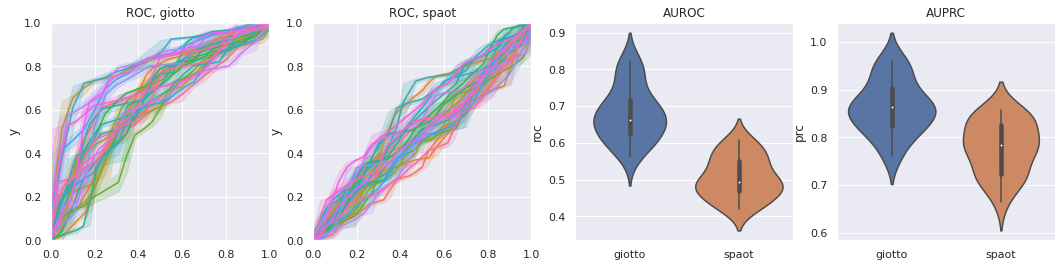

In [56]:
df_plt = get_results(dirs, gio=True)